In [8]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize
from clapton.ansatzes import * 
from clapton.clifford import ParametrizedCliffordCircuit
import numpy as np
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_qec.utils.stim_tools import get_stim_circuits
from qiskit_research.utils.convenience import *

In [9]:
paulis = ["XXI", "IXX", "YYI", "IYY", "ZZI", "IZZ"]
coeffs = np.random.random(len(paulis))

from clapton.depolarization import GateGeneralDepolarizationModel #TODO: check this out 


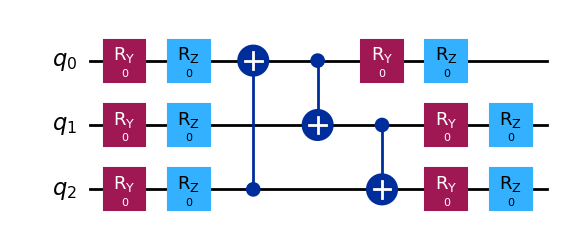

In [10]:
def circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = QuantumCircuit(N)
    for _ in range(reps):
        for i in range(N):
            pcirc.ry(0,i)
        for i in range(N):
            pcirc.rz(0,i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                pcirc.cx(control, target).fix(1)
            else:
                pcirc.cx(control, target)
    for i in range(N):
        pcirc.ry(0,i)
    for i in range(N):
        pcirc.rz(0,i)
    return pcirc

qc=circular_ansatz(3)
qc.draw(output='mpl')

## Altering the Ansatz itself

In [11]:
rng = np.random.default_rng()

TWIRL_GATES_CX = (
        (('I', 'I'), ('I', 'I')),
        (('I', 'X'), ('I', 'X')),
        (('I', 'Y'), ('Z', 'Y')),
        (('I', 'Z'), ('Z', 'Z')),
        (('X', 'I'), ('X', 'X')),
        (('X', 'X'), ('X', 'I')),
        (('X', 'Y'), ('Y', 'Z')),
        (('X', 'Z'), ('Y', 'Y')),
        (('Y', 'I'), ('Y', 'X')),
        (('Y', 'X'), ('Y', 'I')),
        (('Y', 'Y'), ('X', 'Z')),
        (('Y', 'Z'), ('X', 'Y')),
        (('Z', 'I'), ('Z', 'I')),
        (('Z', 'X'), ('Z', 'X')),
        (('Z', 'Y'), ('I', 'Y')),
        (('Z', 'Z'), ('I', 'Z')),
    )

pauli_twirl_dict = {"I":0,"X":1,"Y":2,"Z":3}

def twirled_circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = ParametrizedCliffordCircuit()
    for _ in range(reps):
        for i in range(N):
            pcirc.RY(i)
        for i in range(N):
            pcirc.RZ(i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                
                (before0, before1), (after0, after1) = TWIRL_GATES_CX[
                    rng.integers(len(TWIRL_GATES_CX))]

                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before0])
                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before1])
                pcirc.Q2(control, target).fix(1)
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after0])
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after1])
            else:
                pcirc.Q2(control, target)
    for i in range(N):
        pcirc.RY(i)
    for i in range(N):
        pcirc.RZ(i)

    
    return pcirc

pauli_twirl_list = [twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True) for _ in range(100)]


In [12]:
pauli_twirl_list[0].stim_circuit().diagram()

q0: -I-I-----X-Z-Z-I-Y-@-------------I-I---
             |         |
q1: -I-I-----|---------X-Z-Y-I-X-@---I-I---
             |                   |
q2: -I-I-I-Z-@-------------------X-I-X-I-I-

In [13]:
twirl_ansatz = twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True)

# let's add a noise model where we specify global 1q and 2q gate errors
nm = GateGeneralDepolarizationModel(p1=0.005, p2=0.02)
twirl_ansatz.add_depolarization_model(nm)
# twirl_ansatz.add_pauli_twirl_list(pauli_twirl_list)


In [24]:

if all((pauli_twirl_list[i].number_parametrized_gates) == 12 for i in range(len(pauli_twirl_list))):
    print("All elements have the same size.")
else:
    print("Elements have different sizes.")

Elements have different sizes.


In [15]:
pauli_twirl_list[0].add_depolarization_model(nm)
pauli_twirl_list[0].number_parametrized_gates()

12

In [16]:
twirl_ansatz.read()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
twirl_ansatz.stim_circuit().diagram()

In [ ]:
ks_best, energy_noisy, energy_noiseless = claptonize(
    paulis,
    coeffs,
    twirl_ansatz,
    n_proc=4,           # total number of processes in parallel
    n_starts=4,         # number of random genetic algorithm starts in parallel
    n_rounds=1,         # number of budget rounds, if None it will terminate itself
    callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    budget=20,                        # budget per genetic algorithm instance
)

In [ ]:
ks_best

In [ ]:
energy_noisy, energy_noiseless

In [ ]:
# differrence
np.abs(energy_noisy-energy_noiseless)

In [ ]:
# the corresponding circuit is
twirl_ansatz.assign(ks_best)
twirl_ansatz.snapshot_noiseless().circ_snapshot_noiseless.diagram()